# Retrieval-Augmented Generation: Question Answering based on Custom Dataset with Open Source [LangChain](https://python.langchain.com/en/latest/index.html) Library

## This is a Level-200 Instructor Led Lab

## Acknowledgement

This notebook is based off: https://github.com/gkamradt/langchain-tutorials 

This notebook has been modified for the purpose of providing guided instructor led Level-300 coding experience to those with limited AI/ML and Jupyter notebook experience. The notebook refers to education material to explain concepts to make it easier for the audience. The code is assimilated from various aws-sample repositories. 

## Part 0 - Set Up Your Jupyter notebook

### 00a. Set Kernel for your Jupyter notebook
- instance: ml.t3.medium
- kernel: python 3
- Data Science 3.0

### Follow instructions provided in your lab to set up the Jupyter notebook kernel...

***<span>Important - failure to set the right kernel will result in errors during execution of the Jupyter notebook cells</span>***


### 00b. Update Sagemaker LLM (large language model) Endpoint Name

Update this configuration section to replace the value of 'endpoint_name' with the name of your deployed model

## Part 1 - Review lab overview and set up dependencies

Many use cases such as building a chatbot require text (text2text) generation models)** to respond to user questions with insightful answers. The leading LLM models have picked up a lot of general knowledge in training, but we often need to ingest and use a large library of more specific information.

In this notebook we will demonstrate how to use a LLM to answer questions using a library of documents as a reference, by using document embeddings and retrieval. The embeddings are generated from Huggingface embedding model. 

**This notebook serves a template such that you can easily replace the example dataset by your own to build a custom question and asnwering application.**

### Quick introduction to LangChain and why is it useful for RAG based applications?
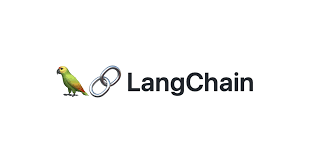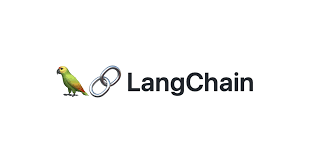

LangChain is a framework for developing applications powered by language models. 

**LLMs are powerful by themselves. Why do we need libraries like LangChain?**
While LLMs are powerful, they are also general in nature (& thus kinda boring & limited). While LLMs can perform many tasks effectively, they are not able to provide specific answers to questions or tasks that require deep domain knowledge or expertise. For example, imagine you want to use an LLM to answer questions about a specific field, like medicine or law. While the LLM may be able to answer general questions about the field, it may not be able to provide more detailed or nuanced answers that require specialized knowledge or expertise. To work around this limitation, LangChain offers a useful approach where the corpus of text is preprocessed by breaking it down into chunks or summaries, embedding them in a vector space, and searching for similar chunks when a question is asked. LangChain also provides a level of abstraction, making it super easy to use. LangChain's popularity has grown exponentially since it was first introduced and being an open source library, it is constantly evolving!

**How do we solve for this problem?**
RAG - Retrieval Augmented Generation. Is a design pattern that enterprise customers could leverage to bring domain context and their artifacts (securely) while leveraging LLMs to answer questions. 


### Set up workshop dependencies

In [ ]:
!pip install --upgrade pip
!pip install Langchain==0.0.231
!pip install transformers faiss-gpu --quiet

In [ ]:
import time
import sagemaker, boto3, json
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from typing import Any, Dict, List, Optional
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.llms.sagemaker_endpoint import ContentHandlerBase

# secure the Sagemaker session, role, region, and other details to work with Sagemaker APIs
sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sm_client = boto3.client("sagemaker", aws_region)
sess = sagemaker.Session()
model_version = "*"

In [ ]:
# functions that work with parsing JSON messages going to and from our Sagemaker Endpoint 
# (i.e. Deployed Sagemaker Jumpstart LLM) 

# invoke the Sagemaker Endpoint with the user query
def query_endpoint_with_json_payload(encoded_json, endpoint_name, content_type="application/json"):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_json
    )
    return response

# parse the Sagemaker Endpoint response to the user query
def parse_response_model(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    return [gen["generated_text"] for gen in model_predictions]

In [ ]:
# an array of multiple models - in our lab we are only using one but you could add additional models here to test them side by side in this lab...
_MODEL_CONFIG_ = {
    
     "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16" : {
        "aws_region": "us-west-2",
        "endpoint_name": "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16",
        "parse_function": parse_response_model,
        "prompt": """{context}\n\nGiven the above context, answer the following question without making up false information:\n{question}\nAnswer: """,
    },
    
}


## Part 2. Ask a question to LLM without providing the context

To better illustrate why we need retrieval-augmented generation (RAG) based approach to solve the question and anwering problem. Let's directly ask the model a question and see how they respond.

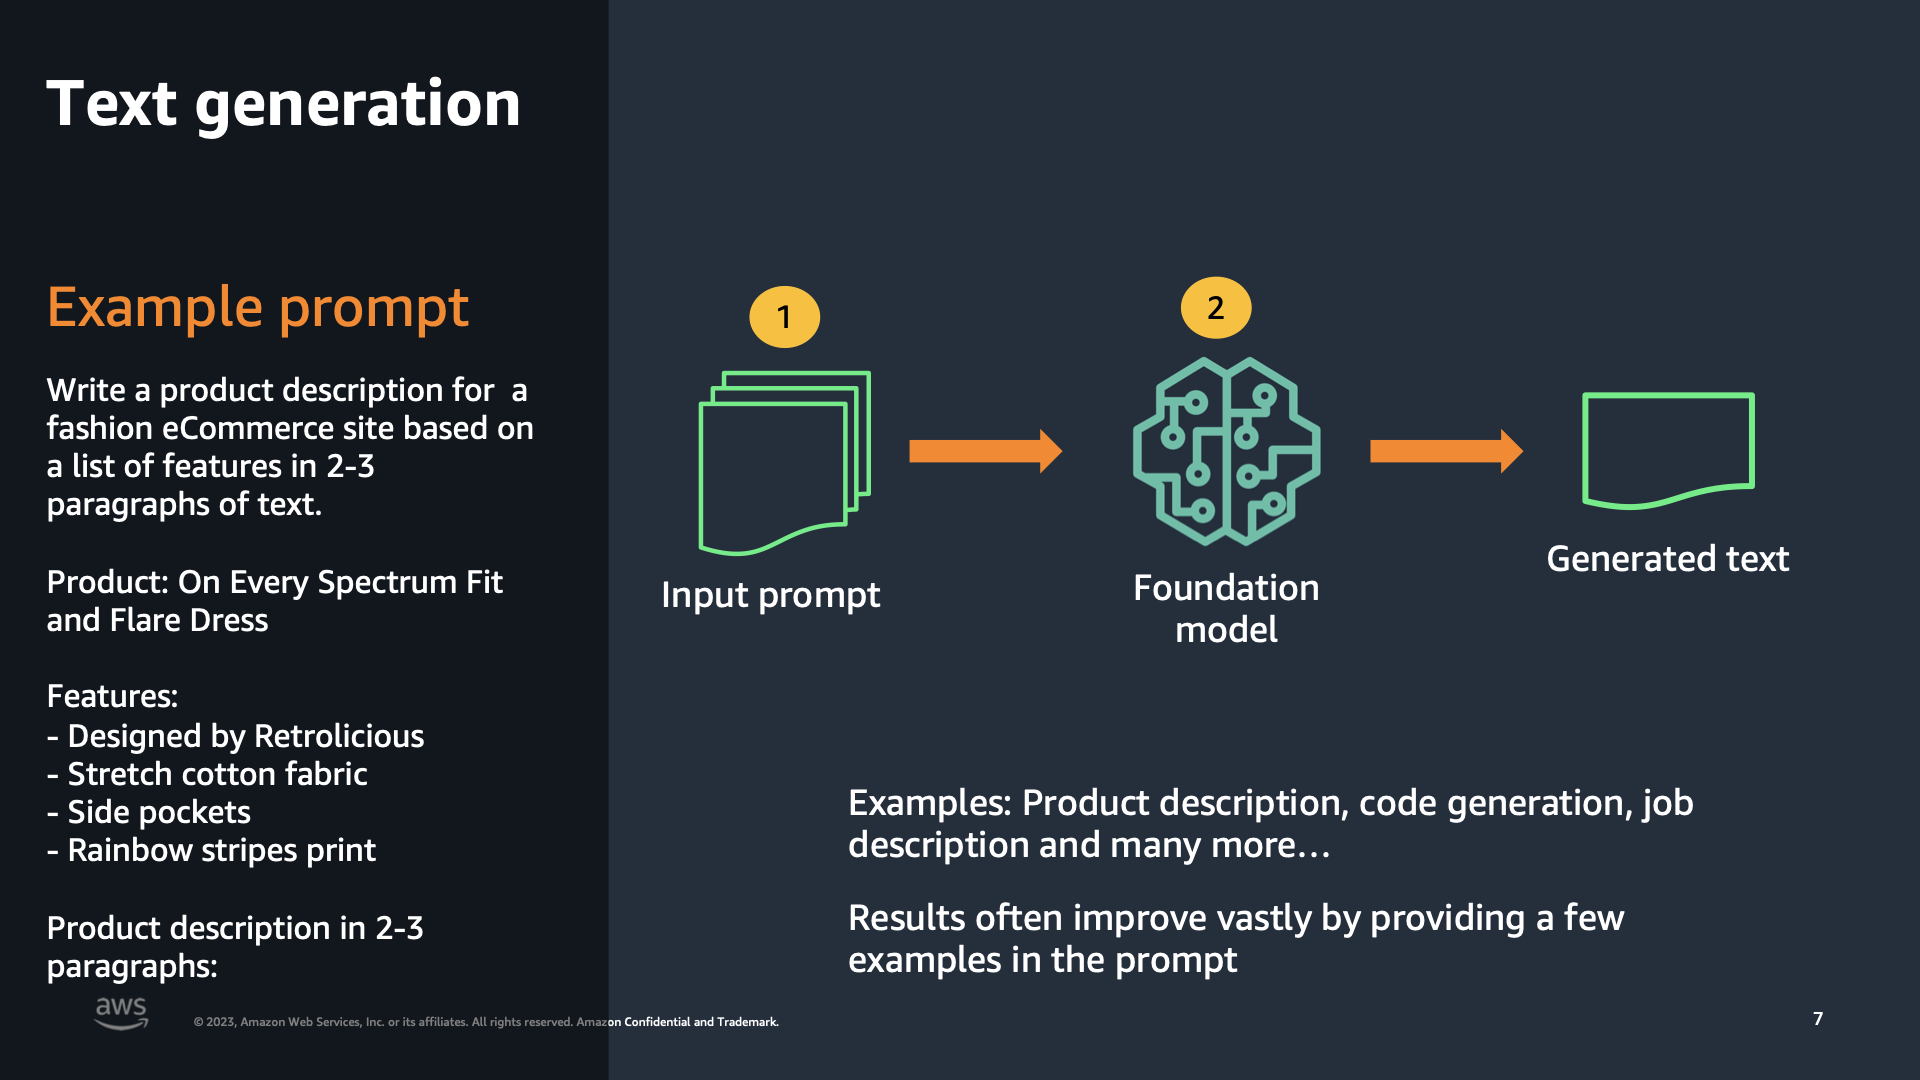

In [ ]:
question = "Do you provide international delivery?"

In [ ]:
# These are hyper-parameters; Hyperparameters are used before inferencing a model because they have a
# direct impact on the performance of the resulting machine learning model. 
# Hyperparameters are used before inferencing a model because they control the behavior of the model, 
# and optimize its performance for the job at hand.
# For this workshop, hyper parameters have been identified for you. 
# If you like, you can use some of these in the code below.
# They will impact the behavior of your LLM response. 

# best_of: None, 
# temperature: None, 
# repetition_penalty: None, 
# top_k: None, 
# top_p: None, 
# typical_p: None, 
# do_sample: false, 
# max_new_tokens: 20, 
# return_full_text: Some(false), 
# stop: [], 
# truncate: None, 
# watermark: false, 
# details: false, 
# seed: None 

In [ ]:
payload = {
    "inputs": question,
    "parameters":{
        "max_new_tokens": 300,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": True,
        "temperature": 0.2
    }
}

# assumingwe have multiple models deployed, we could loop through each of them to see how they respond to our question... 
# get list of all models from our _model_config list
list_of_LLMs = list(_MODEL_CONFIG_.keys())

# for each model, invoke the Sagemaker Endpoint
for model_id in list_of_LLMs:
    endpoint_name = _MODEL_CONFIG_[model_id]["endpoint_name"]
    query_response = query_endpoint_with_json_payload(
        json.dumps(payload).encode("utf-8"), endpoint_name=endpoint_name
    )
    generated_texts = _MODEL_CONFIG_[model_id]["parse_function"](query_response)
    print(f"For model: {model_id}, the generated output is: {generated_texts[0]}\n")

- **<span>!! You will notice that the generated answer is wrong or doesn't make much sense !!</span>** 
- We will improve this in Step 3.

## Part 3. Improve the answer to the same question using **prompt engineering** with insightful context


To better answer the question well, we provide extra contextual information, combine it with a prompt, and send it to model together with the question. Below is an example.


In [ ]:
context = """How long does the delivery take?
We offer only domestic delivery. It should be within 1 working day. 
If you order before 4 pm, it should be delivered before evening the same day. 
If you order after 4 pm, it should be delivered in the next working day."""

In [ ]:

parameters ={
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": True,
        "temperature": 0.2
    }


for model_id in list_of_LLMs:
    endpoint_name = _MODEL_CONFIG_[model_id]["endpoint_name"]
    prompt = _MODEL_CONFIG_[model_id]["prompt"]

    text_input = prompt.replace("{context}", context)
    text_input = text_input.replace("{question}", question)
    payload = {"inputs": text_input, "parameters":parameters}

    query_response = query_endpoint_with_json_payload(
        json.dumps(payload).encode("utf-8"), endpoint_name=endpoint_name
    )
    generated_texts = _MODEL_CONFIG_[model_id]["parse_function"](query_response)
    print(
        f"For model: {model_id}, the generated output is: {generated_texts[0]}"
    )

The output from step 3 tells us the chance to get the correct response significantly correlates with the insightful context you send into the LLM. 

**<span>Now, the question becomes where can I find the insightful context based on the user query? The answer is to use a pre-stored knowledge data base with retrieval augmented generation, as shown in step 4 below</span>.**

## Part 4. Use RAG based approach with [LangChain](https://python.langchain.com/en/latest/index.html) and SageMaker endpoints to build a simplified question and answering application.


We plan to use document embeddings to fetch the most relevant documents in our document knowledge library and combine them with the prompt that we provide to LLM.

To achieve that, we will do following.

1. **Generate embedings for each of document in the knowledge library with HuggingFace embedding model.**
2. **Identify top K most relevant documents based on user query.**
    - 2.1 **For a query of your interest, generate the embedding of the query using the same embedding model.**
    - 2.2 **Search the indexes of top K most relevant documents in the embedding space using in-memory Faiss search.**
    - 2.3 **Use the indexes to retrieve the corresponded documents.**
3. **Combine the retrieved documents with prompt and question and send them into SageMaker LLM.**



Note: The retrieved document/text should be large enough to contain enough information to answer a question; but small enough to fit into the LLM prompt -- maximum sequence length of 1024 tokens. 

---
To build a simiplied QA application with LangChain, we need: 
1. Wrap up our SageMaker endpoints for embedding model and LLM into `langchain.embeddings.SagemakerEndpointEmbeddings` and `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. That requires a small overwritten of `SagemakerEndpointEmbeddings` class to make it compatible with SageMaker embedding model.
2. Prepare the dataset to build the knowledge data base. 

---
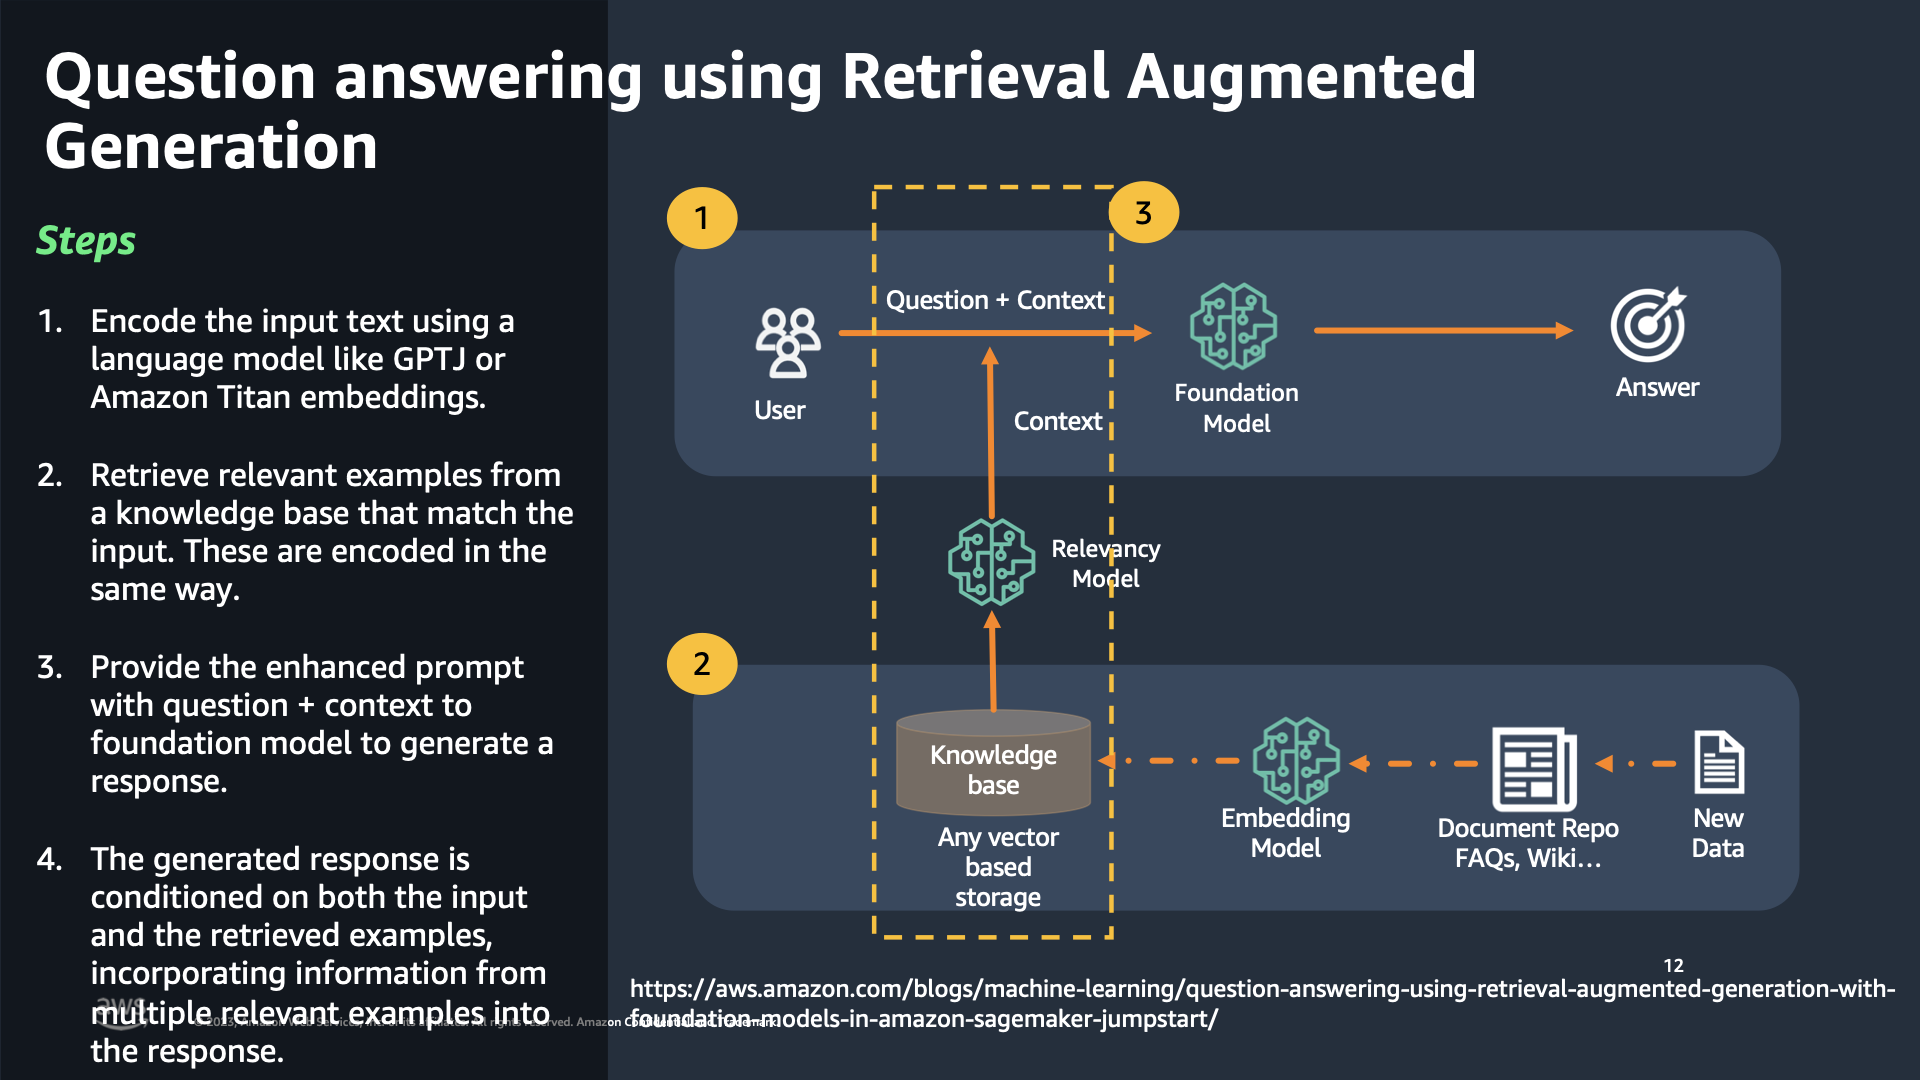


### Embedding

In [ ]:
import langchain
langchain.__version__

In [ ]:
# Initialize the Huggingface Embeddings Model
from langchain.embeddings import HuggingFaceEmbeddings

sm_llm_embeddings = HuggingFaceEmbeddings()

In [ ]:
sm_llm_embeddings.embed_documents(["Rose is red and violets are blue"])[0][:5]

### LLM

Next, we wrap up our SageMaker endpoints for LLM into `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. 

In [ ]:
import json
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

parameters ={
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": 0.2
    }

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generated_text"]


content_handler = ContentHandler()

sm_llm_falcon_instruct = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

Let's test the model inference through LangChain

In [ ]:
sm_llm_falcon_instruct("What flowers are great for mothers day?")

In [ ]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.vectorstores import Chroma, AtlasDB, FAISS
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders import TextLoader
from langchain.indexes.vectorstore import VectorstoreIndexCreator

Use langchain to read the `txt` data. There are multiple built-in functions in LangChain to read different format of files such as `csv`, `html`, and `pdf`. For details, see [LangChain document loaders](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html).

In [ ]:
loader = TextLoader(file_path="./Flower_Shop_FAQs.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=0)
texts = text_splitter.split_documents(documents) ### if you use langchain.document_loaders.TextLoader to load text file. You can uncomment the code
## to split the text.
texts[:3]

**Now, we can build an QA application. <span> LangChain makes it extremly simple with following few lines of code</span>.**

Based on the question below, we can achieven the points in Step 4 with just a few lines of code as shown below.

In [ ]:
question

In [ ]:
index_creator = VectorstoreIndexCreator(
    vectorstore_cls=FAISS,
    embedding=sm_llm_embeddings,
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=252, chunk_overlap=0),
)

In [ ]:
index = index_creator.from_loaders([loader])

In [ ]:
sm_llm_falcon_instruct.model_kwargs = {
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": True,
        "temperature": 0.0001
}
response = index.query(question=question, llm=sm_llm_falcon_instruct)
print(response)

## Part 5. Customize the QA application above with different prompt.

Now, we see how simple it is to use LangChain to achieve question and answering application with just few lines of code. Let's break down the above `VectorstoreIndexCreator` and see what's happening under the hood. Furthermore, we will see how to incorporate a customize prompt rather than using a default prompt with `VectorstoreIndexCreator`.

Firstly, we **generate embedings for each of document in the knowledge library with HuggingFace embedding model.**

In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# Get embedding engine ready
sm_llm_embeddings

# Embedd your texts
docsearch = FAISS.from_documents(texts, sm_llm_embeddings)

In [ ]:
question

Based on the question above, we then **identify top K most relevant documents based on user query, where K = 3 in this setup**.

In [ ]:
docs = docsearch.similarity_search(question, k=3)
docs

Finally, we **combine the retrieved documents with prompt and question and send them into SageMaker LLM.** 

We define a customized prompt as below.

In [ ]:
prompt_template = """{context}\n\nGiven the above context, answer the following question and do not make up any false information:\n{question}\n\nAnswer:"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [ ]:
sm_llm_falcon_instruct.model_kwargs = {
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": True,
        "temperature": 0.1,
}
chain = load_qa_chain(llm=sm_llm_falcon_instruct, prompt=PROMPT)

Send the top 3 most relevant documents and question into LLM to get a answer.

In [ ]:
result = chain({"input_documents": docs, "question": question}, return_only_outputs=True)[
    "output_text"
]

Print the final answer from LLM as below, which is accurate.

In [ ]:
print(result)

## Part 6 - Cleanup

In [ ]:
# delete the endpoints created for testing
#for model_id in _MODEL_CONFIG_:
#    endpoint_name = _MODEL_CONFIG_[model_id]["endpoint_name"]
#    sagemaker_session.delete_endpoint(endpoint_name)